## Clasificación de personas en situación de pobreza

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functions import table

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay, roc_curve)

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.random import set_seed

import warnings
warnings.simplefilter("ignore")

In [2]:
dta = pd.read_csv("./data/data_f.csv", index_col=0)

dta.head()

,edad,hombre,est_sup,colegio_priv,gran_empresa,segundo_trab,ingbrut,urbano,no_pobre
1,28.0,0.0,1.0,0.0,0.0,1.0,1454.500000,1.0,1.0
2,48.0,0.0,0.0,0.0,0.0,1.0,2037.000000,1.0,1.0
3,25.0,0.0,0.0,0.0,0.0,0.0,2037.000000,1.0,1.0
4,16.0,0.0,0.0,0.0,0.0,0.0,2037.000000,1.0,1.0
6,41.0,0.0,0.0,0.0,0.0,1.0,1842.066732,1.0,1.0


### Split y estandarización
Primero definimos las variables que tendremos como explicativas y al target

In [3]:
dta = dta.loc[(dta["ingbrut"] > 0)]
dta["lning"] = np.log(dta["ingbrut"])

X_names = ["edad", "hombre", "est_sup", "colegio_priv", "gran_empresa", "segundo_trab", "urbano", "lning"]
X = dta[X_names]
y = dta["no_pobre"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

### Visualizaciones

In [4]:
print(f"La distribución de la variable `no pobre` es:\n{y.value_counts()}\n")
print(f"La distribución de la variable `no pobre` de entrenamiento es:\n{y_train.value_counts()}\n")
print(f"La distribución de la variable `no pobre` de testing es:\n{y_test.value_counts()}\n")

La distribución de la variable `no pobre` es:
1.0    67059
0.0    13343
Name: no_pobre, dtype: int64

La distribución de la variable `no pobre` de entrenamiento es:
1.0    50339
0.0     9962
Name: no_pobre, dtype: int64

La distribución de la variable `no pobre` de testing es:
1.0    16720
0.0     3381
Name: no_pobre, dtype: int64



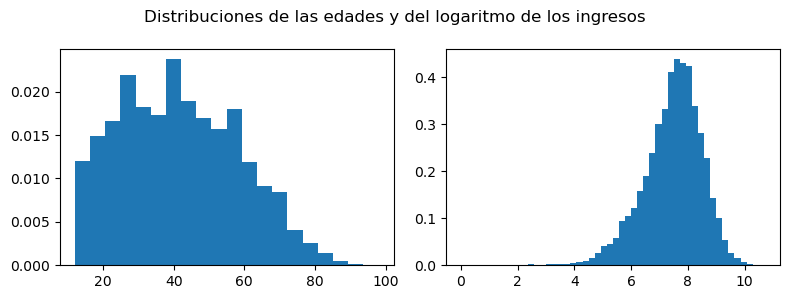

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)

axes[0].hist(dta["edad"], bins=20, density=True)
axes[1].hist(dta["lning"], bins=50, density=True)

fig.suptitle("Distribuciones de las edades y del logaritmo de los ingresos")

plt.savefig("./figures/distribuciones.pdf")
plt.show()

### Relaciones entre las variables
Para poder encontrar relaciones entre las variables, debido a que los modelos de clasificación no necesariante tienen ese objetivo. se puede estimar un modelo Logit

In [6]:
model = sm.Logit(y, X)
results = model.fit()

print(results.summary())

Optimization terminated successfully.
         Current function value: 0.386309
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               no_pobre   No. Observations:                80402
Model:                          Logit   Df Residuals:                    80394
Method:                           MLE   Df Model:                            7
Date:                Thu, 05 Jan 2023   Pseudo R-squ.:                  0.1404
Time:                        16:35:46   Log-Likelihood:                -31060.
converged:                       True   LL-Null:                       -36134.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
edad             0.0031      0.001      5.787      0.000       0.002       0.004
hombre          -0.2254

In [7]:
AME = results.get_margeff(at="overall", method="dydx")

print(AME.summary())

        Logit Marginal Effects       
Dep. Variable:               no_pobre
Method:                          dydx
At:                           overall
                  dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
edad             0.0004   6.49e-05      5.791      0.000       0.000       0.001
hombre          -0.0270      0.002    -10.993      0.000      -0.032      -0.022
est_sup          0.1229      0.006     20.632      0.000       0.111       0.135
colegio_priv     0.1022      0.006     18.329      0.000       0.091       0.113
gran_empresa     0.0660      0.005     12.925      0.000       0.056       0.076
segundo_trab -6.563e-05      0.003     -0.022      0.982      -0.006       0.006
urbano           0.1188      0.003     45.364      0.000       0.114       0.124
lning            0.0141      0.000     29.021      0.000       0.013       0.015


Los resultados son interesantes:

* Las personas con mayor edad tienen menos probabilidad de ser probreza
* El ser hombre no reduce el nivel de pobreza, sino lo vuelve mas probable
* Tener un estudio superior (no universitario, universitario, maestria o doctorado) reduce los niveles de pobreza
* Haber estudiado en un colegio privado reduce la probabilidad de ser pobre
* Vivir en una zona urbana tambien reduce la probabilidad de ser pobre
* _El mas evidente_: recibir mayores ingresos tambien reduce la probabilidad de ser pobre

### Modelo 1: Modelo lineal

In [8]:
ml = LinearRegression().fit(X_train, y_train)

yhat_proba_ml = ml.predict(X_test)
yhat_ml = (yhat_proba_ml >= 0.5).astype(int)

# Estadisticos
score_ml = accuracy_score(y_test, yhat_ml)
conf_ml = confusion_matrix(y_test, yhat_ml, normalize="true")
report_ml = classification_report(y_test, yhat_ml)
fml, tml, thresholds = roc_curve(y_test, yhat_proba_ml)

print(report_ml)

              precision    recall  f1-score   support

         0.0       0.61      0.09      0.15      3381
         1.0       0.84      0.99      0.91     16720

    accuracy                           0.84     20101
   macro avg       0.73      0.54      0.53     20101
weighted avg       0.80      0.84      0.78     20101



### Modelo 2. Logistic Regression

In [9]:
lr = LogisticRegression(random_state=19).fit(X_train, y_train)

yhat_proba_lr = lr.predict_proba(X_test)[:,1]
yhat_lr = lr.predict(X_test)

# Estadisticos
score_lr = accuracy_score(y_test, yhat_lr)
conf_lr = confusion_matrix(y_test, yhat_lr, normalize="true")
report_lr = classification_report(y_test, yhat_lr)
flr, tlr, thresholds = roc_curve(y_test, yhat_proba_lr)

print(report_lr)

              precision    recall  f1-score   support

         0.0       0.58      0.20      0.30      3381
         1.0       0.86      0.97      0.91     16720

    accuracy                           0.84     20101
   macro avg       0.72      0.58      0.60     20101
weighted avg       0.81      0.84      0.81     20101



### Modelo 3. K-Nearest Neighbours

In [10]:
knn = KNeighborsClassifier(10, weights="uniform").fit(X_train, y_train)

yhat_proba_knn = knn.predict_proba(X_test)[:,1]
yhat_knn = knn.predict(X_test)

# Estadisticos
score_knn = accuracy_score(y_test, yhat_knn)
conf_knn = confusion_matrix(y_test, yhat_knn, normalize="true")
report_knn = classification_report(y_test, yhat_knn)
fknn, tknn, thresholds = roc_curve(y_test, yhat_proba_knn)

print(report_knn)

              precision    recall  f1-score   support

         0.0       0.49      0.33      0.39      3381
         1.0       0.87      0.93      0.90     16720

    accuracy                           0.83     20101
   macro avg       0.68      0.63      0.65     20101
weighted avg       0.81      0.83      0.82     20101



### Modelo 4. Decision Tree

In [11]:
tree = DecisionTreeClassifier(criterion="entropy", random_state=19, max_depth=3).fit(X_train, y_train)

yhat_proba_tree = tree.predict_proba(X_test)[:,1]
yhat_tree = tree.predict(X_test)

# Estadisticos
score_tree = accuracy_score(y_test, yhat_tree)
conf_tree = confusion_matrix(y_test, yhat_tree, normalize="true")
report_tree = classification_report(y_test, yhat_tree)
ftree, ttree, thresholds = roc_curve(y_test, yhat_proba_tree)

print(report_tree)

              precision    recall  f1-score   support

         0.0       0.59      0.21      0.31      3381
         1.0       0.86      0.97      0.91     16720

    accuracy                           0.84     20101
   macro avg       0.72      0.59      0.61     20101
weighted avg       0.81      0.84      0.81     20101



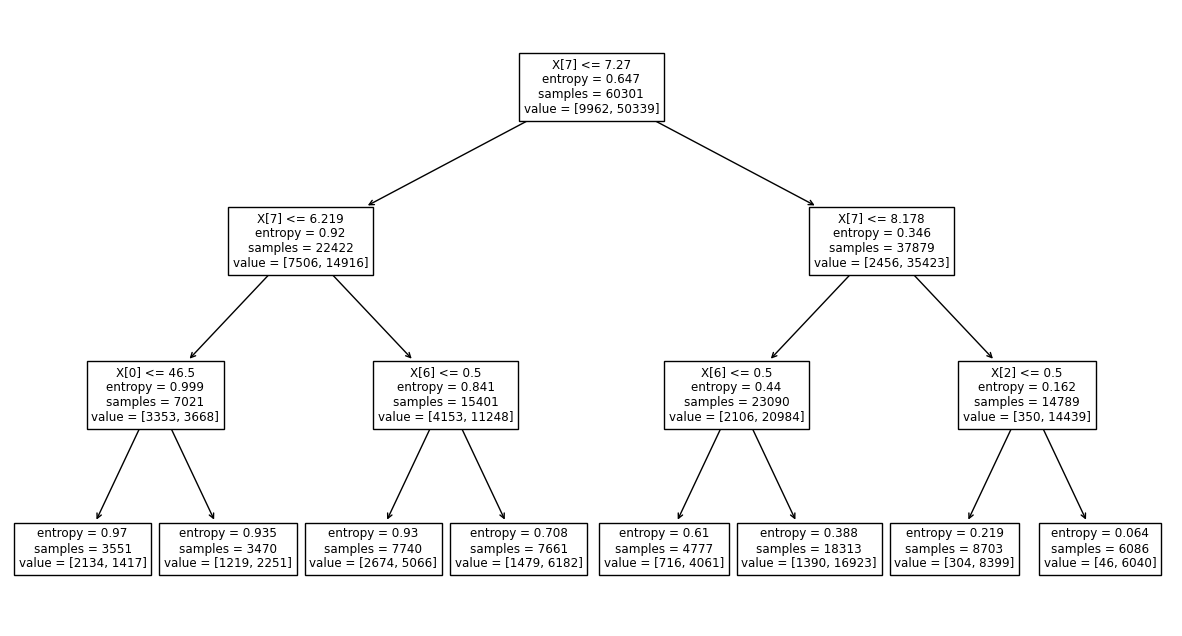

In [12]:
plt.figure(figsize=(15,8))
plot_tree(tree)

plt.savefig("./figures/decision_tree.pdf", bbox_inches="tight", transparent=True)
plt.show()

### Modelo 5. Random Forest

In [13]:
rf = RandomForestClassifier(max_depth=3, random_state=19).fit(X_train, y_train)

yhat_proba_rf = rf.predict_proba(X_test)[:,1]
yhat_rf = rf.predict(X_test)

# Estadisticos
score_rf = accuracy_score(y_test, yhat_rf)
conf_rf = confusion_matrix(y_test, yhat_rf, normalize="true")
report_rf = classification_report(y_test, yhat_rf)
frf, trf, thresholds = roc_curve(y_test, yhat_proba_rf)

print(report_rf)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3381
         1.0       0.83      1.00      0.91     16720

    accuracy                           0.83     20101
   macro avg       0.42      0.50      0.45     20101
weighted avg       0.69      0.83      0.76     20101



### Modelo 6. Neural Network

In [14]:
set_seed(19)

nn = Sequential(
    [
        Input(shape = (8,)),
        Dense(units = 16, activation = "sigmoid", name = "Layer1"),
        Dense(units = 8, activation = "sigmoid", name = "Layer2"),
        Dense(units = 1, activation = "sigmoid", name = "Layer3")
    ]
)

nn.compile(
    loss = BinaryCrossentropy(),
    optimizer = Adam(0.01)
)

results = nn.fit(X_train, y_train, epochs = 20, verbose = False)

yhat_proba_nn = nn.predict(X_test)
yhat_nn = (yhat_proba_nn >= .5).astype(int)

# Estadisticos
score_nn = accuracy_score(y_test, yhat_nn)
conf_nn = confusion_matrix(y_test, yhat_nn, normalize="true")
report_nn = classification_report(y_test, yhat_nn)
fnn, tnn, thresholds = roc_curve(y_test, yhat_proba_nn)

print(report_nn)

629/629 [==============================] - 0s 696us/step
              precision    recall  f1-score   support

         0.0       0.68      0.10      0.17      3381
         1.0       0.84      0.99      0.91     16720

    accuracy                           0.84     20101
   macro avg       0.76      0.54      0.54     20101
weighted avg       0.82      0.84      0.79     20101



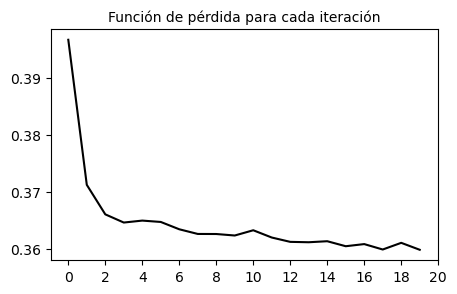

In [15]:
plt.figure(figsize=(5, 3))

plt.plot(results.history["loss"], color="black")

plt.title("Función de pérdida para cada iteración", fontsize = 10)
plt.xticks(np.arange(0, 21, 2))

plt.savefig("./figures/loss-function.pdf")
plt.show()

### Comparativa entre modelos

In [16]:
# 1. Indicadores de ajuste
dict_ajust = {
    "Regresión lineal": score_ml,
    "Regresión logistica": score_lr,
    "KNN": score_knn,
    "Decision tree": score_tree,
    "Random forest": score_rf,
    "Neural networks": score_nn
}

df_score = pd.DataFrame(dict_ajust.items(), columns=["Modelo", "Score"]).set_index("Modelo")
df_score["Score"] = np.round(df_score["Score"], 3)
df_score = df_score.sort_values("Score", ascending=False)

df_score

,Score
Modelo,
Decision tree,0.842
Regresión logistica,0.841
Neural networks,0.841
Regresión lineal,0.837
Random forest,0.832
KNN,0.830


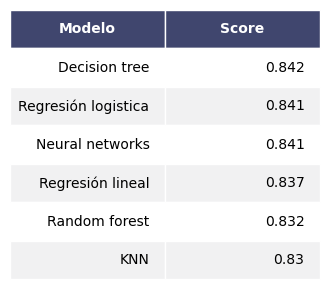

In [17]:
fig, ax = table.render_mpl_table(df_score.reset_index(), header_columns=0, col_width=2.0)
fig.savefig("./figures/score.png")

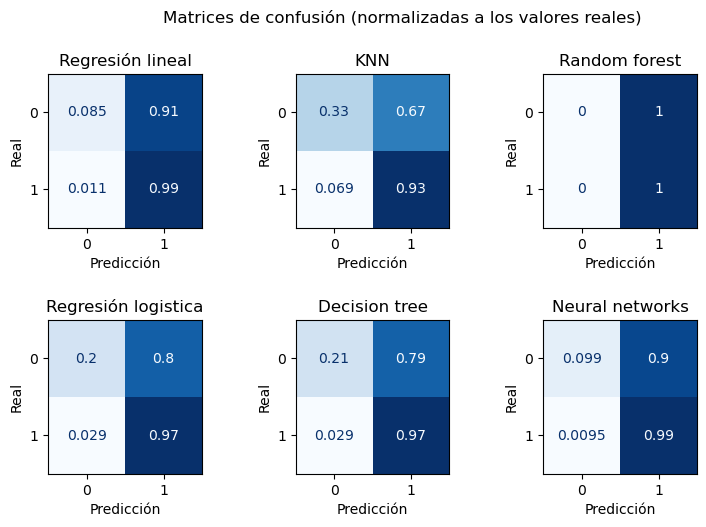

In [18]:
# 2. Matriz de confusion
dict_conf = {
    "Regresión lineal": conf_ml,
    "Regresión logistica": conf_lr,
    "KNN": conf_knn,
    "Decision tree": conf_tree,
    "Random forest": conf_rf,
    "Neural networks": conf_nn
}

conf_names = list(dict_conf.keys())
conf_matrixes = dict_conf.values()


# Figura
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

r = 0; c = 0; i = 0

for matrix in conf_matrixes:
    fig = ConfusionMatrixDisplay(
        confusion_matrix = matrix,
    ).plot(ax = ax[r, c], colorbar = False, cmap=plt.cm.Blues)
    
    ax[r, c].set_title(conf_names[i])
    ax[r, c].set_xlabel("Predicción")
    ax[r, c].set_ylabel("Real")
    
    i += 1
    r += 1
    if r == 2:
        c += 1
        r = 0
    else:
        pass

plt.suptitle("Matrices de confusión (normalizadas a los valores reales)")
plt.subplots_adjust(top=0.9, bottom=0.4, left=0.2, right=0.75, hspace=0.6, wspace=0.5)

plt.savefig("./figures/matrices_confusion.pdf", bbox_inches="tight", transparent=True)
plt.show()

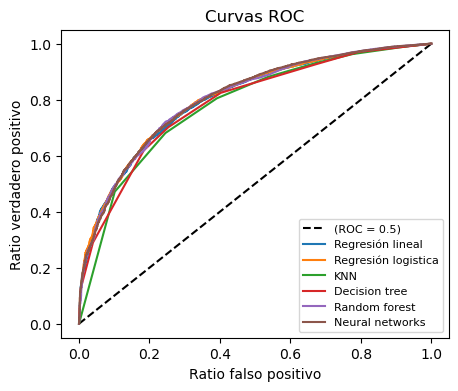

In [19]:
# 3. ROC
dict_conf = {
    "Regresión lineal": [fml, tml],
    "Regresión logistica": [flr, tlr],
    "KNN": [fknn, tknn],
    "Decision tree": [ftree, ttree],
    "Random forest": [frf, trf],
    "Neural networks": [fnn, tnn]
}
keys = list(dict_conf.keys())
values = list(dict_conf.values())


# Figura
plt.figure(figsize=(5, 4))
plt.plot([0, 1], [0, 1], "k--", label="(ROC = 0.5)")

j = 0
for i in values:
    plt.plot(i[0], i[1], label=keys[j])
    j += 1

plt.xlabel("Ratio falso positivo")
plt.ylabel("Ratio verdadero positivo")
plt.title("Curvas ROC")
plt.legend(fontsize=8)

plt.savefig("./figures/roc.pdf", bbox_inches="tight", transparent=True)
plt.savefig("./figures/roc.png", bbox_inches="tight", transparent=True)
plt.show()